## Import Dependencies

In [ ]:
!pip install catboost --quiet
!pip install node2vec --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.5 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import random
from scipy import sparse
import copy

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.utils.extmath import randomized_svd

from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.svm import SVC
from operator import itemgetter

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier

from node2vec import Node2Vec

from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Loading datasets

In [ ]:
class GraphDataset:
    def __init__(self, folder_path=''):

        G = nx.Graph()
        data_adj = np.loadtxt(folder_path + '_A.txt', delimiter=',').astype(int)
        data_graph_indicator = np.loadtxt(folder_path + '_graph_indicator.txt', delimiter=',').astype(int)
        labels = np.loadtxt(folder_path + '_graph_labels.txt', delimiter=',').astype(int)

        data_tuple = list(map(tuple, data_adj))
        G.add_edges_from(data_tuple)
        G.remove_nodes_from(list(nx.isolates(G)))

        # split into graphs

        le = LabelEncoder()
        self.labels_ = le.fit_transform(labels)
        self.n_classes_ = len(le.classes_)
        self.n_graphs_ = len(self.labels_)

        graph_num = data_graph_indicator.max()
        node_list = np.arange(data_graph_indicator.shape[0]) + 1
        self.graphs_ = []

        for i in range(graph_num):

            nodes = node_list[data_graph_indicator == i + 1]
            G_sub = G.subgraph(nodes).copy()

            max_cc = max(nx.connected_components(G_sub), key=len)
            G_sub = G_sub.subgraph(max_cc).copy()
            G_sub.graph['label'] = self.labels_ [i]
            nx.convert_node_labels_to_integers(G_sub)
            self.graphs_.append(G_sub)

        self.graphs_ = np.array(self.graphs_, dtype = object)

        print('Loaded')

In [ ]:
#graphs_name = ['PROTEINS_full']
graphs_name = [ 'PROTEINS_full']
#Provide the link to the directory where the PROTEINS_full dataset is stored
data_pwd = '/content/gdrive/Shareddrives/MNLS/Project/Data/'


In [ ]:
datasets = {}
for gn in graphs_name:
    print(gn)
    datasets[gn] = GraphDataset(folder_path=data_pwd + gn + '/' + gn)

PROTEINS_full
Loaded


### Truncated Laplacian Spectrum as Graph Feature Representation

In [ ]:
def padded_spectral(graph, embedding_dimension=16, normalized=False):

    # Padding with ze
    embedding = np.zeros(embedding_dimension)

    # Usage of networkx graph objects
    #adj_matrix = nx.adj_matrix(graph)
    adj_matrix = nx.adjacency_matrix(graph)
    n_nodes = nx.number_of_nodes(graph)
    k = min(embedding_dimension, n_nodes - 1)

    if normalized:
        laplacian = nx.normalized_laplacian_matrix(graph)
    else:
        laplacian = nx.laplacian_matrix(graph).astype(float)

    try:
        eigenvalues = randomized_svd(laplacian, k)[1]
    except:
        eigenvalues = sparse.linalg.svds(laplacian, k=k, return_singular_vectors=False)
    if len(eigenvalues)>1:
        embedding[-k:] = sorted(eigenvalues)
    return embedding

In [ ]:
def dataset_embedding(dataset, embedding_dim, normalized=False):

    list_graphs = []
    for g in dataset.graphs_:
        x = padded_spectral(g, embedding_dim, normalized)
        y = g.graph['label']

        list_graphs.append((x, y))

    X = np.array([l[0] for l in list_graphs])
    labels = np.array([l[1] for l in list_graphs])

    return X, labels

#### Embedding dimension is set to the percentile 95 of the distribution of graph sizes in each datase

In [ ]:
# Embedding for Proteins

embedding_dims = {'PROTEINS_full': 0}
for e in datasets:
    embedding_dims[e] = int(np.percentile([nx.number_of_nodes(g) for g in datasets[e].graphs_], q=95))

#### TLS extraction for all graphs of all datasets

In [ ]:
%%time

embedded_datasets = {}

for name, dataset in datasets.items():
    X, y = dataset_embedding(dataset, embedding_dims[name])
    embedded_datasets[name] = {'X': X, 'y': y}

<ipython-input-8-8182d4b843d3>:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


CPU times: user 8.37 s, sys: 10.7 s, total: 19.1 s
Wall time: 10.5 s


### Experiments presented in the paper

#### Results for Erdos random graphs

We chose parameter p=0.05 for the graph generation.

<ipython-input-8-8182d4b843d3>:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph)


Text(0.5, 0, 'Number of edge additions')

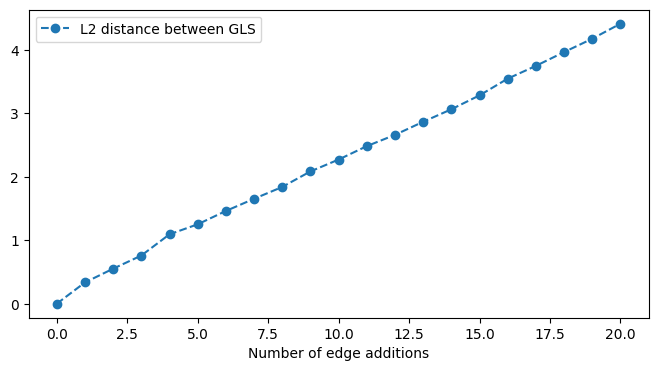

In [ ]:
norm_E = [0]
graph = nx.erdos_renyi_graph(100, 0.05)
graph_ = graph.copy()
E = np.zeros((graph_.number_of_nodes(), graph_.number_of_nodes()))
embedding_dimension=len(graph_)
list_embedding = [np.expand_dims(padded_spectral(graph_, embedding_dimension), 0)]

# list(dct.items())

for i in range(20):
    [u, v] = random.sample(list(graph_.nodes()), 2)
    while (u, v) in graph_.edges():
        [u, v] = random.sample(list(graph_.nodes()), 2)
    graph_.add_edge(u, v)
    E[u, v] += 1
    E[v, u] += 1
    norm_E.append(np.sum(np.absolute(E)))
    list_embedding.append(np.expand_dims(padded_spectral(graph_, embedding_dimension), 0))

embeddings = np.concatenate(list_embedding, axis=0)
embeddings = (embeddings - embeddings[0])**2

plt.figure(figsize=(8, 4))
plt.plot(np.sqrt(embeddings.sum(1)), label='L2 distance between GLS', linestyle='dashed', marker='o');
# plt.plot(norm_E, label='Norm 1 of E');
plt.legend()
plt.xlabel('Number of edge additions')

<ipython-input-8-8182d4b843d3>:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph)


Text(0.5, 0, 'Number of edge withdrawals')

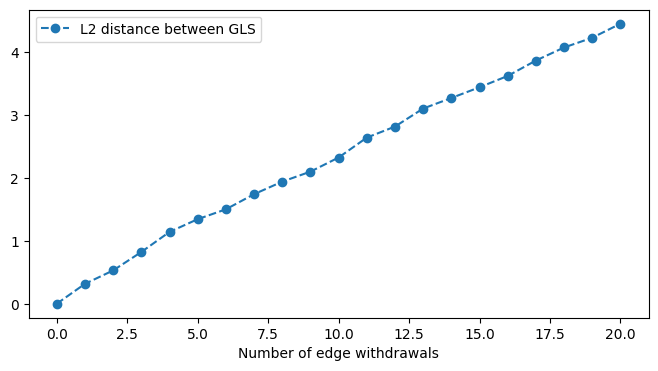

In [ ]:
norm_E = [0]
graph = nx.erdos_renyi_graph(100, 0.05)
graph_ = graph.copy()
E = np.zeros((graph_.number_of_nodes(), graph_.number_of_nodes()))
embedding_dimension=len(graph_)
list_embedding = [np.expand_dims(padded_spectral(graph_, embedding_dimension), 0)]

for i in range(20):
    [(u, v)] = random.sample(list(graph_.edges()), 1)
    graph_.remove_edge(u, v)
    E[u, v] -= 1
    E[v, u] -= 1
    norm_E.append(np.sum(np.absolute(E)))
    list_embedding.append(np.expand_dims(padded_spectral(graph_, embedding_dimension), 0))

embeddings = np.concatenate(list_embedding, axis=0)
embeddings = np.absolute(embeddings - embeddings[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings.sum(1)), label='L2 distance between GLS', linestyle='dashed', marker='o');
# plt.plot(norm_E, label='Norm 1 of E');
plt.legend()
plt.xlabel('Number of edge withdrawals')

Text(0, 0.5, 'L2 distance between TLS')

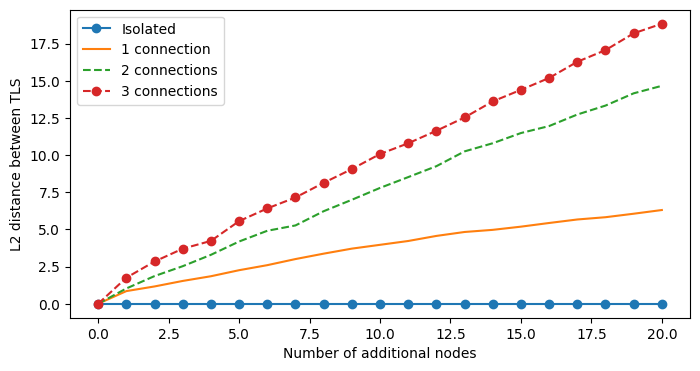

In [ ]:
graph_ = nx.erdos_renyi_graph(28, 0.05)
m = max(list(graph_.nodes()))

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_0 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(list(graph.nodes()), 1)
    graph.add_node(m + j)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_0.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_0 = np.concatenate(list_embedding_aligned_0, axis=0)
embeddings_aligned_0 = (embeddings_aligned_0 - embeddings_aligned_0[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_1 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(list(graph.nodes()), 1)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_1.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_1 = np.concatenate(list_embedding_aligned_1, axis=0)
embeddings_aligned_1 = (embeddings_aligned_1 - embeddings_aligned_1[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_2 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n, m] = random.sample(list(graph.nodes()), 2)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_2.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_2 = np.concatenate(list_embedding_aligned_2, axis=0)
embeddings_aligned_2 = (embeddings_aligned_2 - embeddings_aligned_2[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_3 = [np.expand_dims(nx.laplacian_spectrum(graph), 0)]

for j in range(1, 21):
    [n, m, l] = random.sample(list(graph.nodes()), 3)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    graph.add_edge(m + j, l)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_3.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_3 = np.concatenate(list_embedding_aligned_3, axis=0)
embeddings_aligned_3 = (embeddings_aligned_3 - embeddings_aligned_3[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings_aligned_0.sum(1)), label='Isolated', marker='o');
plt.plot(np.sqrt(embeddings_aligned_1.sum(1)), label='1 connection');
plt.plot(np.sqrt(embeddings_aligned_2.sum(1)), label='2 connections', linestyle='dashed');
plt.plot(np.sqrt(embeddings_aligned_3.sum(1)), label='3 connections', linestyle='dashed', marker='o');
plt.legend()
plt.xlabel('Number of additional nodes')
plt.ylabel('L2 distance between TLS')

Text(0, 0.5, 'Rescaled L2 distance between TLS')

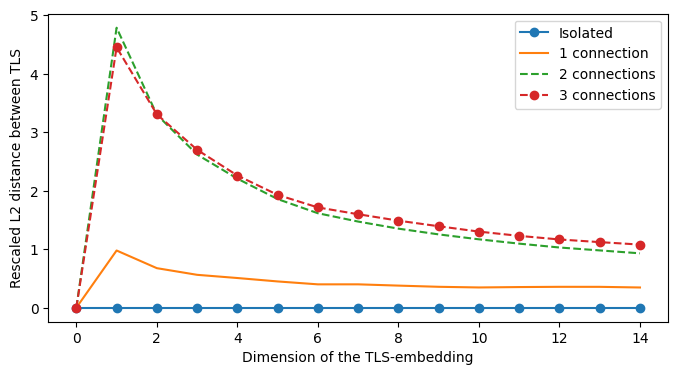

In [ ]:
plt.figure(figsize=(8,4))
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_0[0][:,-j:] - list_embedding_aligned_0[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='Isolated', marker='o')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_1[0][:,-j:] - list_embedding_aligned_1[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='1 connection')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_2[0][:,-j:] - list_embedding_aligned_2[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='2 connections', linestyle='dashed')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_3[0][:,-j:] - list_embedding_aligned_3[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='3 connections', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Dimension of the TLS-embedding')
plt.ylabel('Rescaled L2 distance between TLS')

#### Reults for real molecular graphs

We chose the largest graph of PTC_MR as illustrative example.

In [ ]:
name = 'PROTEINS_full'
n_, i_ = 0, 0
for i, g in enumerate(datasets[name].graphs_):
    n_ = max(g.number_of_nodes(), n_)
    if g.number_of_nodes()==n_:
        i_ = i

print(n_)
print(len(datasets[name].graphs_))

620
1113


In [ ]:
graph = datasets[name].graphs_[i_].copy()
SF = padded_spectral(graph, embedding_dims[name], normalized=False)
dist_to_larger = []

for g in datasets[name].graphs_:
    dist_to_larger.append(np.sqrt(((SF-padded_spectral(g, embedding_dims[name], normalized=False))**2).sum()))

<ipython-input-8-8182d4b843d3>:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph)


In [ ]:
percentiles = [np.percentile(dist_to_larger, q=i) for i in range(25, 101, 25)]

Text(0, 0.5, 'L2 distance between TLS')

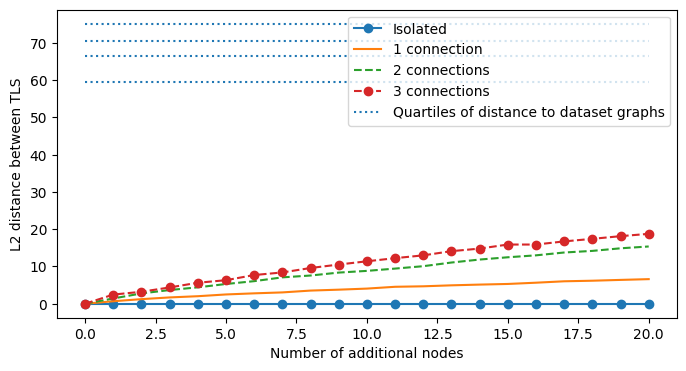

In [ ]:
graph_ = datasets[name].graphs_[10].copy()
m = max(list(graph_.nodes()))

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_0 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(list(graph.nodes()), 1)
    graph.add_node(m + j)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_0.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_0 = np.concatenate(list_embedding_aligned_0, axis=0)
embeddings_aligned_0 = (embeddings_aligned_0 - embeddings_aligned_0[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_1 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n] = random.sample(list(graph.nodes()), 1)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_1.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_1 = np.concatenate(list_embedding_aligned_1, axis=0)
embeddings_aligned_1 = (embeddings_aligned_1 - embeddings_aligned_1[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_2 = [np.expand_dims(nx.laplacian_spectrum(graph)[:embedding_dimension], 0)]

for j in range(1, 21):
    [n, m] = random.sample(list(graph.nodes()), 2)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_2.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_2 = np.concatenate(list_embedding_aligned_2, axis=0)
embeddings_aligned_2 = (embeddings_aligned_2 - embeddings_aligned_2[0])**2

graph = graph_.copy()
embedding_dimension = len(graph)
list_embedding_aligned_3 = [np.expand_dims(nx.laplacian_spectrum(graph), 0)]

for j in range(1, 21):
    [n, m, l] = random.sample(list(graph.nodes()), 3)
    graph.add_node(m + j)
    graph.add_edge(m + j, n)
    graph.add_edge(m + j, m)
    graph.add_edge(m + j, l)
    SF = nx.laplacian_spectrum(graph)
    list_embedding_aligned_3.append(np.expand_dims(SF[-embedding_dimension:], 0))

embeddings_aligned_3 = np.concatenate(list_embedding_aligned_3, axis=0)
embeddings_aligned_3 = (embeddings_aligned_3 - embeddings_aligned_3[0])**2

plt.figure(figsize=(8,4))
plt.plot(np.sqrt(embeddings_aligned_0.sum(1)), label='Isolated', marker='o');
plt.plot(np.sqrt(embeddings_aligned_1.sum(1)), label='1 connection');
plt.plot(np.sqrt(embeddings_aligned_2.sum(1)), label='2 connections', linestyle='dashed');
plt.plot(np.sqrt(embeddings_aligned_3.sum(1)), label='3 connections', linestyle='dashed', marker='o');
plt.hlines(percentiles, xmin=0, xmax=20, linestyle='dotted', label='Quartiles of distance to dataset graphs');
plt.legend()
plt.xlabel('Number of additional nodes')
plt.ylabel('L2 distance between TLS')

Text(0, 0.5, 'Rescaled L2 distance between TLS')

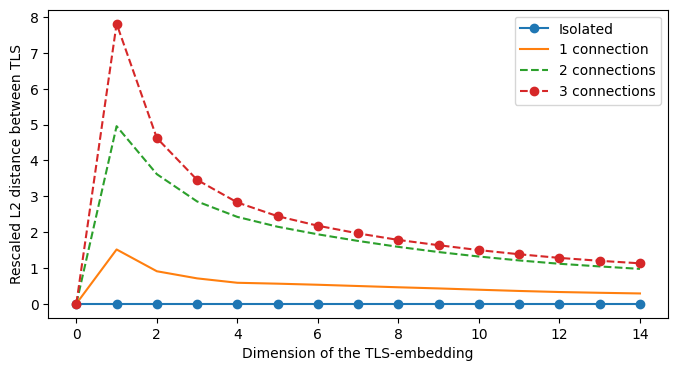

In [ ]:
plt.figure(figsize=(8,4))
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_0[0][:,-j:] - list_embedding_aligned_0[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='Isolated', marker='o')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_1[0][:,-j:] - list_embedding_aligned_1[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='1 connection')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_2[0][:,-j:] - list_embedding_aligned_2[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='2 connections', linestyle='dashed')
plt.plot([0] + [np.sqrt(np.sum((list_embedding_aligned_3[0][:,-j:] - list_embedding_aligned_3[-1][:,-j:])**2))/j
          for j in range(1, 15)], label='3 connections', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Dimension of the TLS-embedding')
plt.ylabel('Rescaled L2 distance between TLS')

#### Classification results with SVM

In [ ]:
p_grid = {"C": [0.5, 1, 5], "gamma": [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5]}

scores = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    skf.get_n_splits(X, y)

    svm = SVC(kernel="rbf")
    scores[name] = []

    for train_index, test_index in skf.split(X, y):
        X_train = itemgetter(*train_index)(X)
        X_test = itemgetter(*test_index)(X)
        y_train = itemgetter(*train_index)(y)
        y_test = itemgetter(*test_index)(y)

        cv = KFold(n_splits=5, shuffle=True, random_state=0)

        clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, n_jobs=-1)
        clf.fit(X_train, y_train)

        scores[name].append((clf.predict(X_test) == y_test).astype(float).mean())

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}, Std: {:2f}'.format(name,
                                                                   X.shape[1],
                                                                   np.mean(scores[name]),
                                                                   np.std(scores[name])))

Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.748383, Std: 0.038392


In [ ]:
# Basic XGBoost Classifier

from xgboost import XGBClassifier

p_grid = {"learning_rate": [0.01, 0.1, 0.2],
          "max_depth": [3, 5, 7],
          "n_estimators": [50, 100, 200],
          "num_class": [1]}

scores = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    xgb = XGBClassifier(n_estimators=1000, max_depth=3, objective='binary:logistic', seed=42, num_class=1)
    scores[name] = []

    xgb.fit(X_train, y_train)

    # calculate accuracy score using the score method
    accuracy = xgb.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                   X.shape[1],
                                                                   accuracy))


Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.718563


In [ ]:
#XGBoost with grid search CV

# define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

# loop through each dataset
for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    # define the XGBClassifier model
    xgb = XGBClassifier(objective='binary:logistic', seed=42, num_class=1)

    # perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # get the best hyperparameters
    best_params = grid_search.best_params_

    # create the XGBClassifier model with the best hyperparameters
    xgb_best = XGBClassifier(n_estimators=best_params['n_estimators'],
                             max_depth=best_params['max_depth'],
                             learning_rate=best_params['learning_rate'],
                             subsample=best_params['subsample'],
                             colsample_bytree=best_params['colsample_bytree'],
                             objective='binary:logistic', seed=42, num_class=1)

    # fit the model with the best hyperparameters
    xgb_best.fit(X_train, y_train)

    # calculate accuracy score using the score method
    accuracy = xgb_best.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                   X.shape[1],
                                                                   accuracy))


#   {'colsample_bytree': 0.5,
#  'learning_rate': 0.001,
#  'max_depth': 7,
#  'n_estimators': 100,
#  'subsample': 0.5}


In [ ]:
#XGBoost best params

best_params

{'colsample_bytree': 0.5,
 'learning_rate': 0.001,
 'max_depth': 7,
 'n_estimators': 100,
 'subsample': 0.5}

In [ ]:
# CatBoost with gridsearch model

# define the parameter grid
param_grid = {
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bylevel': [0.5, 0.7, 1],
}


# loop through each dataset
for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    catboost = CatBoostClassifier(eval_metric='Accuracy', random_seed=42, verbose=False)

    grid_search_result = catboost.grid_search(param_grid,
                                              X=df_X,
                                              y=df_y,
                                              cv=3,
                                              search_by_train_test_split=True,
                                              refit=True,
                                              shuffle=True,
                                              stratified=None,
                                              train_size=0.85,
                                              verbose = True)

    catboost_best = CatBoostClassifier(depth=grid_search_result['params']['depth'],
                                        iterations=grid_search_result['params']['iterations'],
                                        subsample=grid_search_result['params']['subsample'],
                                        rsm=grid_search_result['params']['rsm'],
                                        learning_rate=grid_search_result['params']['learning_rate'],
                                        eval_metric='Accuracy',
                                        random_seed=42, verbose=False)

    catboost_best.fit(X_train, y_train)

    accuracy = catboost_best.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                   X.shape[1],
                                                                   accuracy))

Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.730539


In [ ]:
# Light GBM Model (without GridSearch)

import lightgbm as lgb

params = {'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 15}

scores_lgb = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    lgb_clf = lgb.LGBMClassifier(**params)
    scores_lgb[name] = []

    lgb_clf.fit(X_train, y_train)

    # calculate accuracy score using the score method
    accuracy = lgb_clf.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                  X.shape[1],
                                                                  accuracy))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.718563


In [ ]:
# Gradient Boosting Classifier (without GridSearch)

from sklearn.ensemble import GradientBoostingClassifier

params_gbm = {'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 42}

scores_gbm = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    gbm_clf = GradientBoostingClassifier(**params_gbm)
    scores_gbm[name] = []

    gbm_clf.fit(X_train, y_train)

    # calculate accuracy score using the score method
    accuracy = gbm_clf.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                  X.shape[1],
                                                                  accuracy))



/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.706587


In [ ]:
# Random Forest Classifier (without GridSearch)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import pandas as pd

params_rf = {'n_estimators': 100, 'max_depth': 5, 'random_state': 42}

scores_rf = {}

for name in embedded_datasets:
    X, y = copy.deepcopy(embedded_datasets[name]['X']), copy.deepcopy(embedded_datasets[name]['y'])
    df_X = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42)

    rf_clf = RandomForestClassifier(**params_rf)
    scores_rf[name] = []

    rf_clf.fit(X_train, y_train)

    # calculate accuracy score using the score method
    accuracy = rf_clf.score(X_test, y_test)

    print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format(name,
                                                                  X.shape[1],
                                                                  accuracy))



<ipython-input-26-89e8783580de>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


Dataset: PROTEINS_full, Embedding dim: 105, Accuracy: 0.748503


## Node2Vec Benchmark Comparison

In [ ]:
# Initialize empty list to store all graph embeddings

def node2vec_embed(datasets):

  y = []

  graph_embeddings = []

#  for name, dataset in datasets.items():
  for g in datasets.graphs_:
    # Generate node2vec embeddings for the graph
    node2vec = Node2Vec(g, dimensions=105, walk_length=50, num_walks=3)
    model = node2vec.fit(window=20, min_count=1, batch_words=2)

    embeddings = [model.wv[node] for node in model.wv.index_to_key]

    # Append the graph embeddings to the final list
    graph_embeddings.append(embeddings)

    y.append(g.graph['label'])

    X = np.array([l[0] for l in graph_embeddings])

  return graph_embeddings, y


In [ ]:
for name, dataset in datasets.items():
    X, y = node2vec_embed(dataset)

Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.67it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 73.17it/s]


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 159.57it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 78.05it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 189.64it/s]


Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.73it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 89.73it/s]


Computing transition probabilities:   0%|          | 0/154 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 13.91it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 91.14it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 170.44it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 76.64it/s]


Computing transition probabilities:   0%|          | 0/52 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.67it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 103.97it/s]


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.73it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 95.01it/s]


Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.81it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 92.16it/s]


Computing transition probabilities:   0%|          | 0/285 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.90it/s]


Computing transition probabilities:   0%|          | 0/56 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 48.34it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 69.65it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.71it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.54it/s]


Computing transition probabilities:   0%|          | 0/67 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.32it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 136.23it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 67.85it/s]


Computing transition probabilities:   0%|          | 0/126 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 28.98it/s]


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.68it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 54.01it/s]


Computing transition probabilities:   0%|          | 0/53 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.05it/s]


Computing transition probabilities:   0%|          | 0/47 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 46.93it/s]


Computing transition probabilities:   0%|          | 0/45 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 52.74it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 124.25it/s]


Computing transition probabilities:   0%|          | 0/58 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.12it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 134.95it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 70.61it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 66.33it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 47.22it/s]


Computing transition probabilities:   0%|          | 0/45 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.65it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 49.89it/s]


Computing transition probabilities:   0%|          | 0/89 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.30it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.31it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 154.27it/s]


Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.85it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 93.53it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 64.67it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 44.49it/s]


Computing transition probabilities:   0%|          | 0/72 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.07it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 90.89it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 55.46it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.87it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 203.20it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 56.87it/s]


Computing transition probabilities:   0%|          | 0/180 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.69it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 87.51it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 105.74it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 51.43it/s]


Computing transition probabilities:   0%|          | 0/57 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 46.23it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.22it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 133.75it/s]


Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 48.39it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 119.31it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 59.42it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 81.91it/s]


Computing transition probabilities:   0%|          | 0/122 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 27.46it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 94.71it/s]


Computing transition probabilities:   0%|          | 0/70 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.39it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.32it/s]


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 177.78it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 62.08it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 52.50it/s]


Computing transition probabilities:   0%|          | 0/41 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.22it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 130.19it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 86.85it/s]


Computing transition probabilities:   0%|          | 0/72 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 31.14it/s]


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 380.76it/s]


Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Computing transition probabilities:   0%|          | 0/59 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.56it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.50it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 39.70it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.72it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 47.99it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 48.08it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 74.60it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 51.94it/s]


Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.19it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.92it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 68.75it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 48.71it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.51it/s]


Computing transition probabilities:   0%|          | 0/170 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Computing transition probabilities:   0%|          | 0/186 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 10.59it/s]


Computing transition probabilities:   0%|          | 0/58 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.85it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 162.28it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 195.34it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.29it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.20it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.85it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.82it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 47.01it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 17.55it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.13it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 27.82it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.00it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 189.95it/s]


Computing transition probabilities:   0%|          | 0/244 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


Computing transition probabilities:   0%|          | 0/80 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.91it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 82.88it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.97it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 63.35it/s]


Computing transition probabilities:   0%|          | 0/113 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 19.11it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 104.66it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 77.81it/s]


Computing transition probabilities:   0%|          | 0/37 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.90it/s]


Computing transition probabilities:   0%|          | 0/41 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 23.03it/s]


Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.74it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 38.11it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.08it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.58it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 39.79it/s]


Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.03it/s]


Computing transition probabilities:   0%|          | 0/156 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 12.95it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 59.21it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 108.72it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 91.54it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 95.26it/s]


Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 199.99it/s]


Computing transition probabilities:   0%|          | 0/55 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.18it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 66.85it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 113.00it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 88.33it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.84it/s]


Computing transition probabilities:   0%|          | 0/49 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 44.75it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.40it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 81.83it/s]


Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.83it/s]


Computing transition probabilities:   0%|          | 0/69 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.52it/s]


Computing transition probabilities:   0%|          | 0/122 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 72.57it/s]


Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 36.49it/s]


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 17.59it/s]


Computing transition probabilities:   0%|          | 0/136 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.11it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 74.31it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 67.29it/s]


Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 71.45it/s]


Computing transition probabilities:   0%|          | 0/45 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.02it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 82.64it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 83.42it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 91.75it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 134.14it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 85.90it/s]


Computing transition probabilities:   0%|          | 0/126 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.47it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 74.54it/s]


Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.16it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 44.26it/s]


Computing transition probabilities:   0%|          | 0/82 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.04it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 70.65it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.36it/s]


Computing transition probabilities:   0%|          | 0/188 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


Computing transition probabilities:   0%|          | 0/133 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 19.95it/s]


Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.16it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.32it/s]


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.10it/s]


Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.19it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 180.97it/s]


Computing transition probabilities:   0%|          | 0/87 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.92it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 105.92it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 86.51it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 115.95it/s]


Computing transition probabilities:   0%|          | 0/75 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 27.38it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 85.55it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.01it/s]


Computing transition probabilities:   0%|          | 0/80 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.22it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 151.44it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 64.34it/s]


Computing transition probabilities:   0%|          | 0/152 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.62it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.98it/s]


Computing transition probabilities:   0%|          | 0/229 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


Computing transition probabilities:   0%|          | 0/124 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.61it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 44.89it/s]


Computing transition probabilities:   0%|          | 0/73 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 36.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.74it/s]


Computing transition probabilities:   0%|          | 0/57 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.15it/s]


Computing transition probabilities:   0%|          | 0/71 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.51it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 69.24it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 161.54it/s]


Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.66it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 83.99it/s]


Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 56.05it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 112.38it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.33it/s]


Computing transition probabilities:   0%|          | 0/63 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.98it/s]


Computing transition probabilities:   0%|          | 0/72 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.52it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 69.37it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 161.53it/s]


Computing transition probabilities:   0%|          | 0/148 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.79it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.58it/s]


Computing transition probabilities:   0%|          | 0/139 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.37it/s]


Computing transition probabilities:   0%|          | 0/52 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.42it/s]


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 21.64it/s]


Computing transition probabilities:   0%|          | 0/61 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.31it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 127.86it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 132.45it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 155.30it/s]


Computing transition probabilities:   0%|          | 0/55 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.30it/s]


Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 49.50it/s]


Computing transition probabilities:   0%|          | 0/66 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.13it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 19.19it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.41it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 116.53it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 88.11it/s]


Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 54.82it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 69.48it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 66.77it/s]


Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 49.19it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.21it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.03it/s]


Computing transition probabilities:   0%|          | 0/37 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 51.15it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 115.56it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 89.53it/s]


Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 39.01it/s]


Computing transition probabilities:   0%|          | 0/59 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Computing transition probabilities:   0%|          | 0/66 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.46it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 49.17it/s]


Computing transition probabilities:   0%|          | 0/47 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]


Computing transition probabilities:   0%|          | 0/152 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.95it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.65it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 21.14it/s]


Computing transition probabilities:   0%|          | 0/273 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Computing transition probabilities:   0%|          | 0/78 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 23.31it/s]


Computing transition probabilities:   0%|          | 0/47 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.12it/s]


Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 65.28it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 47.25it/s]


Computing transition probabilities:   0%|          | 0/46 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 31.31it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 63.61it/s]


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 21.86it/s]


Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.99it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 76.51it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.51it/s]


Computing transition probabilities:   0%|          | 0/41 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 31.40it/s]


Computing transition probabilities:   0%|          | 0/504 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 72.21it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 69.49it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 88.86it/s]


Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 63.35it/s]


Computing transition probabilities:   0%|          | 0/64 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.33it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 73.86it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 173.95it/s]


Computing transition probabilities:   0%|          | 0/136 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 64.31it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.73it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.63it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.43it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.76it/s]


Computing transition probabilities:   0%|          | 0/69 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 15.40it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 56.02it/s]


Computing transition probabilities:   0%|          | 0/46 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.83it/s]


Computing transition probabilities:   0%|          | 0/208 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.40it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.70it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 44.54it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 104.07it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.01it/s]


Computing transition probabilities:   0%|          | 0/108 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 12.26it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 70.44it/s]


Computing transition probabilities:   0%|          | 0/35 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 41.35it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.25it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 38.33it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 36.64it/s]


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 14.71it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 66.33it/s]


Computing transition probabilities:   0%|          | 0/226 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 71.60it/s]


Computing transition probabilities:   0%|          | 0/71 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.96it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.23it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 55.55it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.61it/s]


Computing transition probabilities:   0%|          | 0/246 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 39.38it/s]


Computing transition probabilities:   0%|          | 0/117 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Computing transition probabilities:   0%|          | 0/63 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 39.14it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 36.94it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 86.97it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.70it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 52.18it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 116.39it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 52.94it/s]


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.59it/s]


Computing transition probabilities:   0%|          | 0/111 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.77it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 76.59it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 32.14it/s]


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.31it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.09it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 53.75it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 68.43it/s]


Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 38.94it/s]


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.48it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 126.81it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 26.47it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 96.26it/s]


Computing transition probabilities:   0%|          | 0/79 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.86it/s]


Computing transition probabilities:   0%|          | 0/74 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.74it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.77it/s]


Computing transition probabilities:   0%|          | 0/328 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


Computing transition probabilities:   0%|          | 0/153 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 16.39it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 107.48it/s]


Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 95.54it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 97.40it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 149.80it/s]


Computing transition probabilities:   0%|          | 0/159 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 10.35it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 157.29it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 74.86it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 62.64it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 71.06it/s]


Computing transition probabilities:   0%|          | 0/81 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.98it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 46.59it/s]


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 18.97it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 119.58it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.59it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.35it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.28it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 66.87it/s]


Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.41it/s]


Computing transition probabilities:   0%|          | 0/63 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 33.73it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 90.12it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 55.74it/s]


Computing transition probabilities:   0%|          | 0/17 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 115.12it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 70.80it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 88.76it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 149.01it/s]


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 80.57it/s]


Computing transition probabilities:   0%|          | 0/55 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.89it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.82it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 60.26it/s]


Computing transition probabilities:   0%|          | 0/70 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.65it/s]


Computing transition probabilities:   0%|          | 0/45 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 51.51it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 74.56it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 98.70it/s]


Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.29it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 76.49it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 123.38it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 100.33it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 67.06it/s]


Computing transition probabilities:   0%|          | 0/60 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.89it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 100.88it/s]


Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 248.80it/s]


Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 54.58it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 68.23it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.17it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 85.18it/s]


Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.45it/s]


Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 53.03it/s]


Computing transition probabilities:   0%|          | 0/12 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 157.22it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 67.35it/s]


Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 95.08it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 110.28it/s]


Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 23.95it/s]


Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 47.90it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 110.89it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 77.60it/s]


Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 171.95it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 75.75it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 128.55it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 81.04it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 62.33it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.74it/s]


Computing transition probabilities:   0%|          | 0/52 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 37.32it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 103.21it/s]


Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.87it/s]


Computing transition probabilities:   0%|          | 0/125 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 19.06it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 83.98it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.36it/s]


Computing transition probabilities:   0%|          | 0/82 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 61.70it/s]


Computing transition probabilities:   0%|          | 0/37 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 35.76it/s]


Computing transition probabilities:   0%|          | 0/8 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 161.47it/s]


Computing transition probabilities:   0%|          | 0/69 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.96it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 101.55it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 72.89it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 62.99it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 78.24it/s]


Computing transition probabilities:   0%|          | 0/72 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.53it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 80.13it/s]


Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 88.07it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 109.28it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 62.58it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 78.72it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 56.88it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 98.53it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 95.08it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 122.54it/s]


Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 321.59it/s]


Computing transition probabilities:   0%|          | 0/64 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.72it/s]


Computing transition probabilities:   0%|          | 0/74 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 29.68it/s]


Computing transition probabilities:   0%|          | 0/73 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 30.92it/s]


Computing transition probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 65.38it/s]


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 63.15it/s]


Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.79it/s]


Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 42.37it/s]


Computing transition probabilities:   0%|          | 0/122 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Computing transition probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.64it/s]


Computing transition probabilities:   0%|          | 0/37 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.25it/s]


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 102.85it/s]


Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 140.56it/s]


Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 22.18it/s]


Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.03it/s]


Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 94.43it/s]


Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 21.46it/s]


Computing transition probabilities:   0%|          | 0/23 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.74it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.84it/s]


Computing transition probabilities:   0%|          | 0/9 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 78.13it/s]


Computing transition probabilities:   0%|          | 0/11 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 57.17it/s]


Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 20.89it/s]


Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.94it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]


Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 65.00it/s]


Computing transition probabilities:   0%|          | 0/84 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 50.99it/s]


Computing transition probabilities:   0%|          | 0/59 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 11.50it/s]


Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 51.41it/s]


Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 40.90it/s]


Computing transition probabilities:   0%|          | 0/64 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 28.50it/s]


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 54.70it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 58.26it/s]


Computing transition probabilities:   0%|          | 0/93 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 25.35it/s]


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 24.50it/s]


Computing transition probabilities:   0%|          | 0/38 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 63.49it/s]


Computing transition probabilities:   0%|          | 0/21 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 86.20it/s]


Computing transition probabilities:   0%|          | 0/47 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 34.45it/s]


Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 59.99it/s]


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 21.42it/s]


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 28.17it/s]


Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 132.84it/s]


Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 38.53it/s]


Computing transition probabilities:   0%|          | 0/46 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:00<00:00, 43.71it/s]


KeyboardInterrupt: ignored

In [ ]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

In [ ]:
# split each embedding into its own column
df_X_final = df_X.apply(lambda row: pd.Series(row[0]), axis=1)

In [ ]:
#Node2vec embeddings under CatBoostClassifier

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import copy

# define the parameter grid
param_grid = {
'iterations': [100, 500, 1000],
'depth': [3, 5, 7],
'learning_rate': [0.1, 0.01, 0.001],
'subsample': [0.5, 0.7, 1],
'colsample_bylevel': [0.5, 0.7, 1],
}

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the CatBoostClassifier model
catboost = CatBoostClassifier(eval_metric='Accuracy',
                              learning_rate = 0.0001,
                              depth = 5,
                              iterations = 1000,
                              subsample = 0.9,
                              random_seed=42, verbose=False)

catboost.fit(X_train, y_train)

accuracy = catboost.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Protein Datset',
                                                                df_X_final.shape[1],
                                                                accuracy))


Dataset: Protein Datset, Embedding dim: 105, Accuracy: 0.688623


In [ ]:
# CatBoost Classifier

#node2vec embeddings data

param_grid = {
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bylevel': [0.5, 0.7, 1],
}

X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

catboost = CatBoostClassifier(eval_metric='Accuracy', random_seed=42, verbose=False)

grid_search_result = catboost.grid_search(param_grid,
                                          X=df_X_final,
                                          y=df_y,
                                          cv=3,
                                          search_by_train_test_split=True,
                                          refit=True,
                                          shuffle=True,
                                          stratified=None,
                                          train_size=0.85,
                                          verbose = True)

catboost_best = CatBoostClassifier(depth=grid_search_result['params']['depth'],
                                    iterations=grid_search_result['params']['iterations'],
                                    subsample=grid_search_result['params']['subsample'],
                                    rsm=grid_search_result['params']['rsm'],
                                    learning_rate=grid_search_result['params']['learning_rate'],
                                    eval_metric='Accuracy',
                                    random_seed=42, verbose=False)

catboost_best.fit(X_train, y_train)

accuracy = catboost_best.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Protein Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))

# {'depth': 7,
#  'iterations': 1000,
#  'subsample': 0.5,
#  'rsm': 0.5,
#  'learning_rate': 0.01}



bestTest = 0.748502994
bestIteration = 20

0:	loss: 0.7485030	best: 0.7485030 (0)	total: 1.05s	remaining: 4m 13s

bestTest = 0.754491018
bestIteration = 13

1:	loss: 0.7544910	best: 0.7544910 (1)	total: 1.75s	remaining: 3m 30s

bestTest = 0.7664670659
bestIteration = 92

2:	loss: 0.7664671	best: 0.7664671 (2)	total: 2.37s	remaining: 3m 9s

bestTest = 0.748502994
bestIteration = 20

3:	loss: 0.7485030	best: 0.7664671 (2)	total: 4.84s	remaining: 4m 49s

bestTest = 0.754491018
bestIteration = 13

4:	loss: 0.7544910	best: 0.7664671 (2)	total: 6.6s	remaining: 5m 14s

bestTest = 0.7664670659
bestIteration = 92

5:	loss: 0.7664671	best: 0.7664671 (2)	total: 8.32s	remaining: 5m 28s

bestTest = 0.748502994
bestIteration = 20

6:	loss: 0.7485030	best: 0.7664671 (2)	total: 12.4s	remaining: 6m 57s

bestTest = 0.754491018
bestIteration = 13

7:	loss: 0.7544910	best: 0.7664671 (2)	total: 17.5s	remaining: 8m 32s

bestTest = 0.7664670659
bestIteration = 92

8:	loss: 0.7664671	best: 0.7664671 (2)	tota

In [ ]:
# XGB Classifier (with GridSearch)

# define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the XGBClassifier model
xgb = XGBClassifier(objective='binary:logistic', seed=42, num_class=1)

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# create the XGBClassifier model with the best hyperparameters
xgb_best = XGBClassifier(n_estimators=best_params['n_estimators'],
                          max_depth=best_params['max_depth'],
                          learning_rate=best_params['learning_rate'],
                          subsample=best_params['subsample'],
                          colsample_bytree=best_params['colsample_bytree'],
                          objective='binary:logistic', seed=42, num_class=1)

# fit the model with the best hyperparameters
xgb_best.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = xgb_best.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))


# Node2Vec best params
# {'colsample_bytree': 0.5,
#  'learning_rate': 0.001,
#  'max_depth': 5,
#  'n_estimators': 500,
#  'subsample': 1}


Dataset: Proteins Dataset, Embedding dim: 105, Accuracy: 0.670659


In [ ]:
# Random Forest Clssifier with Gridsearch

# define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the RandomForestClassifier model
rfc = RandomForestClassifier(n_estimators=500,
                                   max_depth=5,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   random_state=42)

# fit the model with the best hyperparameters
rfc.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = rfc.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))


<ipython-input-68-5325f3130c2f>:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Dataset: Proteins Dataset, Embedding dim: 105, Accuracy: 0.676647


In [ ]:
# LightGBM Classifier without GridSearch

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the LGBMClassifier model
lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.001, n_estimators=1000)

# fit the LGBMClassifier model
lgbm.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = lgbm.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Dataset: Proteins Dataset, Embedding dim: 105, Accuracy: 0.664671


In [ ]:
# Gradient Boosting Classifier without GridSearch

# define the GradientBoostingClassifier model
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.001, max_depth=3, random_state=42)

# fit the GradientBoostingClassifier model
gbc.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = gbc.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dataset: Proteins Dataset, Embedding dim: 105, Accuracy: 0.682635


In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the SVM model
svm = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)

# fit the SVM model
svm.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = svm.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))


Dataset: Proteins Dataset, Embedding dim: 105, Accuracy: 0.694611


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_final, df_y, test_size=0.15, random_state=42)

# define the RandomForestClassifier model
rfc = RandomForestClassifier(n_estimators=500,
                                   max_depth=5,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   random_state=42)

# # perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# create the RandomForestClassifier model with the best hyperparameters
rfc_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   min_samples_split=best_params['min_samples_split'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   random_state=42)

# fit the model with the best hyperparameters
rfc_best.fit(X_train, y_train)

# calculate accuracy score using the score method
accuracy = rfc_best.score(X_test, y_test)

print('Dataset: {}, Embedding dim: {}, Accuracy: {:2f}'.format('Proteins Dataset',
                                                                df_X_final.shape[1],
                                                                accuracy))
